In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import time
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import torch
from model import TGAPolypSeg
from utils import create_dir, seeding, label_dictionary
from utils import calculate_metrics
from train import DATASET, DataLoader
from text2embed import Text2Embed

In [2]:
def load_names(path):
    images = glob(os.path.join(path + '/data' + '/test' + '/images' + "/*.bmp"))
    masks = glob(os.path.join(path + '/data' + '/test' + '/labels' + "/*.bmp"))
    return images, masks

def load_data(path):
        test_x, test_y = load_names(path)
        label_dict = label_dictionary()
        test_label = len(test_x) * [label_dict['polyp']]
        return (test_x, test_y, test_label)

In [3]:
path = "C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/DLthon_torch"
size = (256, 256)
device = torch.device('cuda')

(test_x, test_y, test_label) = load_data(path)
test_dataset = DATASET(test_x, test_label, test_y, size, transform=None)
test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=2
    )

c:\Users\ZAKAR\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
def process_mask(y_pred):
    y_pred = y_pred[0].cpu().numpy()
    y_pred = np.squeeze(y_pred, axis=0)
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = y_pred * 255
    y_pred = np.array(y_pred, dtype=np.uint8)
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=2)
    return y_pred

def print_score(metrics_score):
    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    f2 = metrics_score[5]/len(test_x)
    miou = metrics_score[6]/len(test_x)

    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f} - F2: {f2:1.4f} - mIoU: {miou:1.4f}")

def show_image_subplot(image, title, position, total, cmap=None):
    plt.subplot(1, total, position)
    if type(image) == Image.Image:
        image = np.array(image)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb, cmap=cmap)
    plt.title(title)

def evaluate(model, save_path, test_x, test_y, test_l, size, embed):
    metrics_score_1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, l, y) in tqdm(enumerate(zip(test_x, test_l, test_y)), total=len(test_x)):
        name = y.split("/")[-1].split(".")[0]

        """ Image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, size)
        save_img = image
        save_img = Image.fromarray(save_img)
        image = np.transpose(image, (2, 0, 1))
        image = image/255.0
        image = np.expand_dims(image, axis=0)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        image = image.to(device)

        """ Label """
        label = []
        for word in l:
            word_embed = embed.to_embed(word)[0]
            label.append(word_embed)
        label = np.array(label)
        label = np.expand_dims(label, axis=0)
        label = torch.from_numpy(label)
        label = label.to(device)

        """ Mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, size)
        save_mask = mask
        save_mask = np.expand_dims(save_mask, axis=-1)
        save_mask = np.concatenate([save_mask, save_mask, save_mask], axis=2)
        save_mask = Image.fromarray(save_mask)
        blended = Image.blend(save_img, save_mask, alpha=0.5)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)
        mask = mask.to(device)

        with torch.no_grad():
            """ FPS calculation """
            start_time = time.time()
            p1, p2, p3 = model(image, label)

            p1 = torch.sigmoid(p1)
            p2 = torch.softmax(p2, axis=1).cpu().numpy()[0]
            p3 = torch.softmax(p3, axis=1).cpu().numpy()[0]

            end_time = time.time() - start_time
            time_taken.append(end_time)

            """ Evaluation metrics """
            score_1 = calculate_metrics(mask, p1)
            metrics_score_1 = list(map(add, metrics_score_1, score_1))
            p1 = process_mask(p1)

        plt.figure(figsize=(18,6))
        show_image_subplot(blended, 'Output', 1, 3)
        show_image_subplot(p1, 'Prediction', 2, 3, cmap='viridis')
        show_image_subplot(save_mask, 'Target', 3, 3, cmap='gray')
        plt.show()

        """ Save the image - mask - pred """
        line = np.ones((size[0], 10, 3)) * 255
        cat_images = np.concatenate([save_img, line, save_mask, line, p1], axis=1)

        save_image_name = f"{name}"
        # p2 = np.argmax(p2)
        # p3 = np.argmax(p3)
        #
        # if p2 == 0:
        #     save_image_name += "-one_polyp"
        # else:
        #     save_image_name += "-multiple_polyp"
        #
        # if p3 == 0: save_image_name += "-small"
        # if p3 == 1: save_image_name += "-medium"
        # if p3 == 2: save_image_name += "-large"

        cv2.imwrite(f"{save_path}/all/{name}.jpg", cat_images)
        cv2.imwrite(f"{save_path}/mask/{name}.jpg", p1)
        
    print_score(metrics_score_1)
    mean_time_taken = np.mean(time_taken)
    mean_fps = 1/mean_time_taken
    print("Mean FPS: ", mean_fps)

  0%|          | 0/1 [00:00<?, ?it/s]

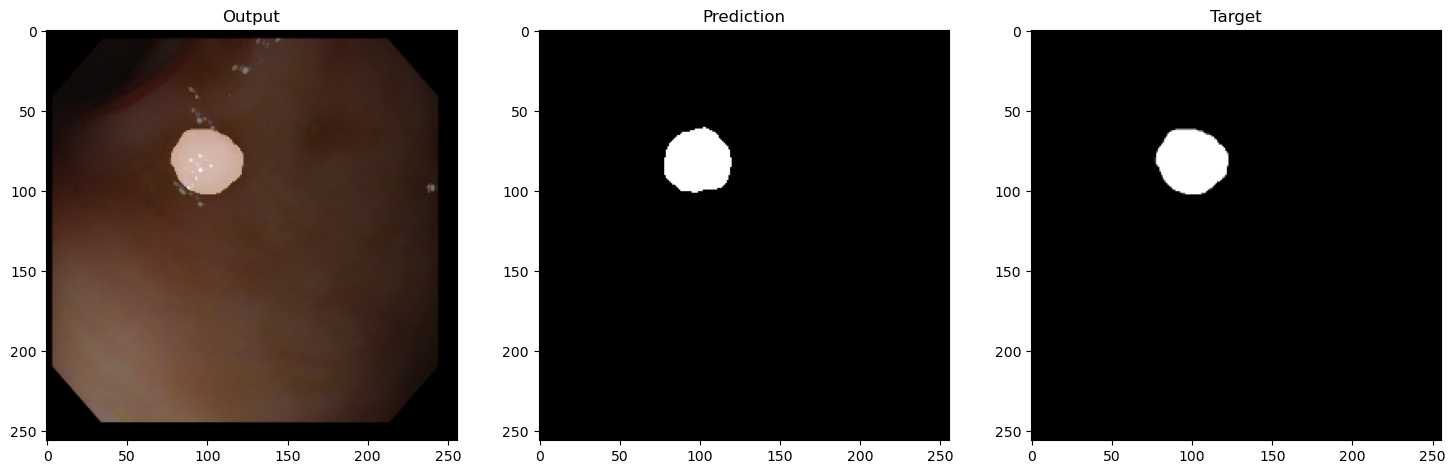

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

Jaccard: 0.8794 - F1: 0.9358 - Recall: 0.9092 - Precision: 0.9642 - Acc: 0.9973 - F2: 0.9196 - mIoU: 0.8794
Mean FPS:  0.6841581403208753


In [5]:
if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Load the checkpoint """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TGAPolypSeg()
    model = model.to(device)
    checkpoint_path = os.path.join(path + '/checkpoint.pth')
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    """ Test dataset """

    embed = Text2Embed()
    save_path = f"results/Kvasir-SEG/"
    save_path = f"results/Kvasir-SEG"
    size = (256, 256)
    create_dir(f"{save_path}/all")
    create_dir(f"{save_path}/mask")
    evaluate(model, save_path, test_x, test_y, test_label, size, embed)